In [1]:
#Firstly, let us import the required packages:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import os
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
# Create path for hc
path = os.getcwd()
dirname = os.path.dirname(path)

# dataset path
train_path = dirname + "/data/all_deg/train"
test_path = dirname + "/data/all_deg/test"
val_path = dirname + "/data/all_deg/val"

# # dataset path
# train_path = dirname + "/data/8_deg/train"
# test_path = dirname + "/data/8_deg/test"
# val_path = dirname + "/data/8_deg/val"

# dataset path
# train_path = dirname + "/data/cnn_data/train"
# test_path = dirname + "/data/cnn_data/test"
# val_path = dirname + "/data/cnn_data/val"

#labeling the dataset according to respective folder(walk through)
x_train=[]
for folder in os.listdir(train_path):
    if folder == '.DS_Store':
        continue
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]
for folder in os.listdir(test_path):
    if folder == '.DS_Store':
        continue
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

x_val=[]
for folder in os.listdir(val_path):
    if folder == '.DS_Store':
        continue
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)


# convert the image pixels to a numpy array
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0


train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

# label
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

# Model building
# re-size all the images(vgg19 expect only 224x224)
IMAGE_SIZE = [224, 224]

## Loading VGG16 model
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])#pooling='avg')

# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False


# New Flatten layer after the last pooling layer in VGG19 model and define new classifier
flat_l = Flatten()(vgg19.output)
# class_l = Dense(1024, activation='sigmoid')(flat_l)
# drop_out = Dropout(0.5)(class_l)
prediction = Dense(2, activation='softmax')(flat_l) # sigmoid is for binary classification


# # create a model object
model = Model(inputs=vgg19.input, outputs=prediction)
# # view the structure of the model
model.summary()

Found 187 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-16 01:17:27.249046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 01:17:27.249315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
# Model compiling and training
BATCH_SIZE = 32
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
train_generator = train_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

val_generator = train_gen.flow(val_x, val_y, batch_size=BATCH_SIZE)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1,restore_best_weights=False)

history = model.fit( train_generator, validation_data= val_generator,#callbacks=[es],
                    epochs=30, batch_size=BATCH_SIZE,shuffle=True)

2022-03-16 01:19:15.310261: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-03-16 01:19:15.596253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.9339 - accuracy: 0.4973

2022-03-16 01:19:25.744050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 13s 2s/step - loss: 1.9339 - accuracy: 0.4973 - val_loss: 1.0439 - val_accuracy: 0.5532
Epoch 2/30
6/6 [==============================] - 12s 2s/step - loss: 0.8844 - accuracy: 0.5401 - val_loss: 0.9549 - val_accuracy: 0.5532
Epoch 3/30
6/6 [==============================] - 12s 2s/step - loss: 0.9702 - accuracy: 0.4813 - val_loss: 0.7053 - val_accuracy: 0.6170
Epoch 4/30
6/6 [==============================] - 12s 2s/step - loss: 0.8255 - accuracy: 0.5561 - val_loss: 0.7943 - val_accuracy: 0.5106
Epoch 5/30
6/6 [==============================] - 11s 2s/step - loss: 0.7208 - accuracy: 0.5508 - val_loss: 0.7144 - val_accuracy: 0.4894
Epoch 6/30
6/6 [==============================] - 14s 2s/step - loss: 0.6309 - accuracy: 0.6471 - val_loss: 0.7619 - val_accuracy: 0.5957
Epoch 7/30
6/6 [==============================] - 13s 2s/step - loss: 0.6625 - accuracy: 0.6150 - val_loss: 0.7443 - val_accuracy: 0.5532
Epoch 8/30
6/6 [=============================

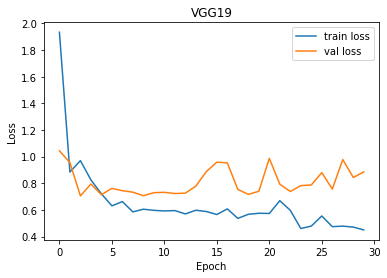

In [4]:
# plot loss
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
#plt.plot(history.history['val_accuracy'], label='val acc',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG19')
plt.legend()
plt.savefig('vgg19-loss.png',dpi=300)
plt.show()

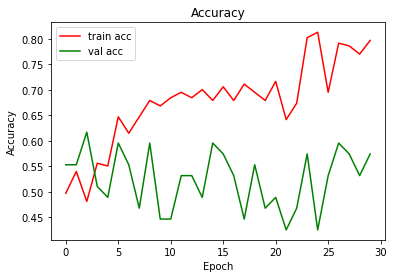

In [5]:
# plot accuracy
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

In [6]:
#Evaluation
model.evaluate(test_x,test_y,batch_size=32)
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

# Accuracy
accuracy = accuracy_score(y_pred,test_y)

2022-03-16 01:26:14.525960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step - loss: 0.8234 - accuracy: 0.6034


2022-03-16 01:26:18.291121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [4]:
# classification report
print(classification_report(y_pred,test_y))

NameError: name 'classification_report' is not defined

In [3]:
#confusion matrix
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)

NameError: name 'confusion_matrix' is not defined

### ROC curve

In [2]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.83')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  plt.savefig('roc_curve.png',dpi=300)
  plt.show()    
  
plot_roc_curve (fpr,tpr)

NameError: name 'fpr' is not defined

## VGG16

In [117]:
# Create path for hc
path = os.getcwd()
dirname = os.path.dirname(path)

# dataset path
train_path = dirname + "/data/all_deg/train"
test_path = dirname + "/data/all_deg/test"
val_path = dirname + "/data/all_deg/val"

# # dataset path
# train_path = dirname + "/data/8_deg/train"
# test_path = dirname + "/data/8_deg/test"
# val_path = dirname + "/data/8_deg/val"

# # dataset path
# train_path = dirname + "/data/cnn_data/train"
# test_path = dirname + "/data/cnn_data/test"
# val_path = dirname + "/data/cnn_data/val"

#labeling the dataset according to respective folder(walk through)
x_train=[]
for folder in os.listdir(train_path):
    if folder == '.DS_Store':
        continue
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]
for folder in os.listdir(test_path):
    if folder == '.DS_Store':
        continue
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

x_val=[]
for folder in os.listdir(val_path):
    if folder == '.DS_Store':
        continue
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)


# convert the image pixels to a numpy array
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0


train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

# label
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

# Model building
# re-size all the images(vgg19 expect only 224x224)
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
vgg19 = VGG16(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])#pooling='avg')

# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False


# New Flatten layer after the last pooling layer in VGG19 model and define new classifier
flat_l = Flatten()(vgg16.output)
# class_l = Dense(1024, activation='sigmoid')(flat_l)
# drop_out = Dropout(0.5)(class_l)
prediction = Dense(2, activation='softmax')(flat_l) # sigmoid is for binary classification


# # create a model object
model = Model(inputs=vgg16.input, outputs=prediction)
# # view the structure of the model
model.summary()

Found 187 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
   

In [118]:
# Model compiling and training
BATCH_SIZE = 32
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
train_generator = train_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

val_generator = train_gen.flow(val_x, val_y, batch_size=BATCH_SIZE)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1,restore_best_weights=False)

history = model.fit( train_generator, validation_data= val_generator,#callbacks=[es],
                    epochs=50, batch_size=BATCH_SIZE,shuffle=True)

Epoch 1/50


2022-03-15 21:45:39.192058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.5882

2022-03-15 21:45:51.588642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 15s 3s/step - loss: 1.1864 - accuracy: 0.5882 - val_loss: 1.3775 - val_accuracy: 0.5532
Epoch 2/50
6/6 [==============================] - 13s 2s/step - loss: 1.0089 - accuracy: 0.4545 - val_loss: 0.7520 - val_accuracy: 0.6170
Epoch 3/50
6/6 [==============================] - 11s 2s/step - loss: 0.9261 - accuracy: 0.5561 - val_loss: 0.9292 - val_accuracy: 0.4468
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 0.7771 - accuracy: 0.5187 - val_loss: 0.8698 - val_accuracy: 0.5745
Epoch 5/50
6/6 [==============================] - 10s 2s/step - loss: 0.6816 - accuracy: 0.5829 - val_loss: 0.7242 - val_accuracy: 0.5745
Epoch 6/50
6/6 [==============================] - 10s 2s/step - loss: 0.6065 - accuracy: 0.6524 - val_loss: 0.7025 - val_accuracy: 0.6170
Epoch 7/50
6/6 [==============================] - 11s 2s/step - loss: 0.5849 - accuracy: 0.7059 - val_loss: 0.7650 - val_accuracy: 0.5532
Epoch 8/50
6/6 [=============================

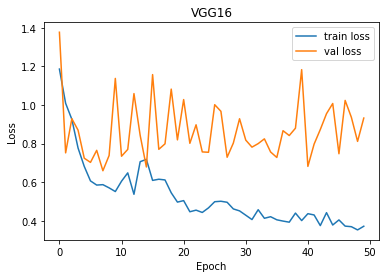

In [119]:
# plot loss
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
#plt.plot(history.history['val_accuracy'], label='val acc',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16')
plt.legend()
#plt.savefig('vgg16-loss.png',dpi=300)
plt.show()

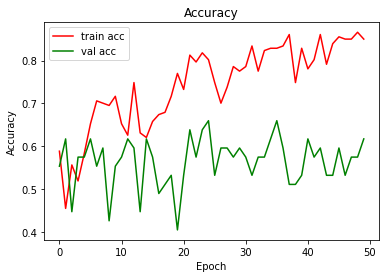

In [120]:
# plot accuracy
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

In [121]:
#Evaluation
model.evaluate(test_x,test_y,batch_size=32)
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

# Accuracy
accuracy = accuracy_score(y_pred,test_y)

2022-03-15 21:57:11.192453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 2s/step - loss: 0.8984 - accuracy: 0.5862


2022-03-15 21:57:14.760207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [122]:
# classification report
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.15      0.67      0.25         6
           1       0.94      0.58      0.71        52

    accuracy                           0.59        58
   macro avg       0.55      0.62      0.48        58
weighted avg       0.86      0.59      0.67        58



In [123]:
#confusion matrix
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)

[[ 4  2]
 [22 30]]
0.5769230769230769
0.6666666666666666
0.5456730769230769


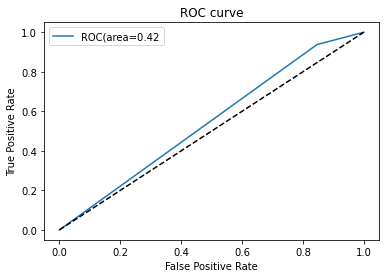

In [124]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.42')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  #plt.savefig('vgg16_roc_curve.png',dpi=300)
  plt.show() 

plot_roc_curve (fpr,tpr) 

# Inception V3

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


# Create path for hc
path = os.getcwd()
dirname = os.path.dirname(path)

# # dataset path
# train_path = dirname + "/data/all_deg/train"
# test_path = dirname + "/data/all_deg/test"
# val_path = dirname + "/data/all_deg/val"

# # dataset path
# train_path = dirname + "/data/8_deg/train"
# test_path = dirname + "/data/8_deg/test"
# val_path = dirname + "/data/8_deg/val"

# dataset path
train_path = dirname + "/data/cnn_data/train"
test_path = dirname + "/data/cnn_data/test"
val_path = dirname + "/data/cnn_data/val"

#labeling the dataset according to respective folder(walk through)
x_train=[]
for folder in os.listdir(train_path):
    if folder == '.DS_Store':
        continue
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]
for folder in os.listdir(test_path):
    if folder == '.DS_Store':
        continue
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

x_val=[]
for folder in os.listdir(val_path):
    if folder == '.DS_Store':
        continue
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)


# convert the image pixels to a numpy array
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0


train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

# label
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

# re-size all the images to this
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
base_inception = InceptionV3(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])

# don't train existing weights
for layer in base_inception.layers:
    layer.trainable = False


# our layers - you can add more if you want
last_l = Flatten()(base_inception.output)
prediction = Dense(2, activation='softmax')(last_l) 


# # create a model object
model = Model(inputs=base_inception.input, outputs=prediction)
# # view the structure of the model
model.summary()

Found 39 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 9 images belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-15 22:13:27.617724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-15 22:13:27.617877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [3]:
# Model compiling and training
BATCH_SIZE = 32
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
train_generator = train_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

val_generator = train_gen.flow(val_x, val_y, batch_size=BATCH_SIZE)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1,restore_best_weights=False)

history = model.fit( train_generator, validation_data= val_generator,#callbacks=[es],
                    epochs=50, batch_size=BATCH_SIZE,shuffle=True)

2022-03-15 22:13:34.717801: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-03-15 22:13:36.270239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 8.4286 - accuracy: 0.4615

2022-03-15 22:13:38.088881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step - loss: 8.4286 - accuracy: 0.4615 - val_loss: 3.8210 - val_accuracy: 0.5556
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 2.3667 - accuracy: 0.5385 - val_loss: 4.1863 - val_accuracy: 0.5556
Epoch 3/50
2/2 [==============================] - 1s 876ms/step - loss: 2.3209 - accuracy: 0.6154 - val_loss: 2.8428 - val_accuracy: 0.4444
Epoch 4/50
2/2 [==============================] - 1s 918ms/step - loss: 3.2505 - accuracy: 0.5897 - val_loss: 6.5735 - val_accuracy: 0.3333
Epoch 5/50
2/2 [==============================] - 1s 1s/step - loss: 2.2868 - accuracy: 0.5128 - val_loss: 0.8731 - val_accuracy: 0.6667
Epoch 6/50
2/2 [==============================] - 1s 288ms/step - loss: 2.0150 - accuracy: 0.5641 - val_loss: 0.7656 - val_accuracy: 0.5556
Epoch 7/50
2/2 [==============================] - 1s 300ms/step - loss: 2.4306 - accuracy: 0.6154 - val_loss: 0.6919 - val_accuracy: 0.7778
Epoch 8/50
2/2 [========================

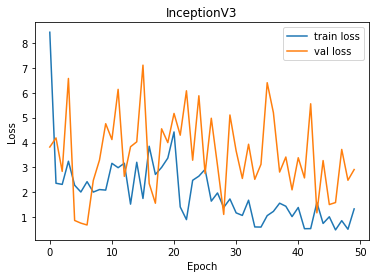

In [7]:
# plot loss
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
#plt.plot(history.history['val_accuracy'], label='val acc',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('InceptionV3')
plt.legend()
plt.savefig('vgg16-loss.png',dpi=300)
plt.show()

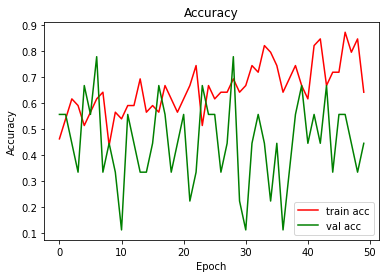

In [5]:
# plot accuracy
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

In [6]:
#Evaluation
model.evaluate(test_x,test_y,batch_size=32)
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

# Accuracy
accuracy = accuracy_score(y_pred,test_y)

2022-03-15 22:16:25.252915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 1.9573 - accuracy: 0.4167


2022-03-15 22:16:26.780927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [8]:
#confusion matrix
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)

[[1 3]
 [4 4]]
0.5
0.25
0.3857142857142857


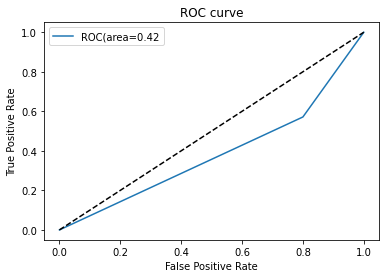

In [9]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.38')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  #plt.savefig('vgg16_roc_curve.png',dpi=300)
  plt.show() 

plot_roc_curve (fpr,tpr) 

# ResNet50

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
# re-size all the images to this
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])

# don't train existing weights
for layer in base_resnet.layers:
    layer.trainable = False


# our layers - you can add more if you want
last_l = Flatten()(base_resnet.output)
prediction = Dense(2, activation='softmax')(last_l) 


# # create a model object
model = Model(inputs=base_resnet.input, outputs=prediction)
# # view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [12]:
BATCH_SIZE = 32
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
train_generator = train_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

val_generator = train_gen.flow(val_x, val_y, batch_size=BATCH_SIZE)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=5,verbose=1,restore_best_weights=False)

history = model.fit( train_generator, validation_data= val_generator,#callbacks=[es],
                    epochs=50, batch_size=BATCH_SIZE,shuffle=True)

Epoch 1/50


2022-03-15 22:20:30.912684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 2.9364 - accuracy: 0.5385

2022-03-15 22:20:33.531411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step - loss: 2.9364 - accuracy: 0.5385 - val_loss: 6.7819 - val_accuracy: 0.4444
Epoch 2/50
2/2 [==============================] - 2s 532ms/step - loss: 5.4659 - accuracy: 0.5128 - val_loss: 5.0527 - val_accuracy: 0.5556
Epoch 3/50
2/2 [==============================] - 1s 1s/step - loss: 5.1346 - accuracy: 0.5641 - val_loss: 3.1735 - val_accuracy: 0.5556
Epoch 4/50
2/2 [==============================] - 2s 853ms/step - loss: 2.9751 - accuracy: 0.4872 - val_loss: 2.0121 - val_accuracy: 0.4444
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 1.0167 - accuracy: 0.4615 - val_loss: 1.4728 - val_accuracy: 0.5556
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 1.3008 - accuracy: 0.5641 - val_loss: 0.7396 - val_accuracy: 0.4444
Epoch 7/50
2/2 [==============================] - 1s 1s/step - loss: 2.2359 - accuracy: 0.4103 - val_loss: 1.7905 - val_accuracy: 0.4444
Epoch 8/50
2/2 [==============================

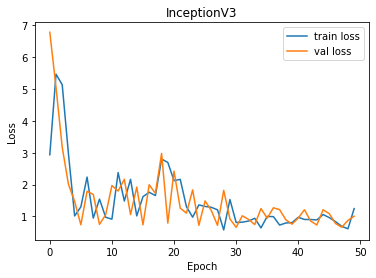

In [13]:
# plot loss
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
#plt.plot(history.history['val_accuracy'], label='val acc',color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('InceptionV3')
plt.legend()
plt.savefig('resnet-loss.png',dpi=300)
plt.show()

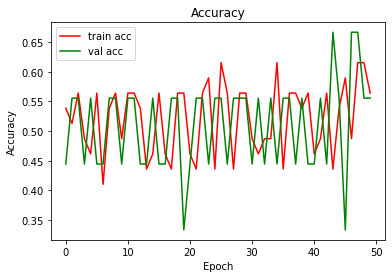

In [14]:
# plot accuracy
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

In [15]:
#Evaluation
model.evaluate(test_x,test_y,batch_size=32)
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

# Accuracy
accuracy = accuracy_score(y_pred,test_y)

2022-03-15 22:25:18.822248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.8177 - accuracy: 0.5833


2022-03-15 22:25:20.175451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [16]:
#confusion matrix
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)

[[0 0]
 [5 7]]
0.5833333333333334
nan
0.5


/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_9509/1484585502.py:15: RuntimeWarning: invalid value encountered in true_divide
  specificity = TN/float(TN+FP)


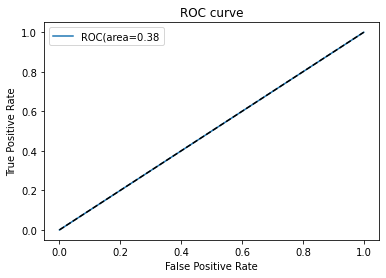

In [17]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.38')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  #plt.savefig('vgg16_roc_curve.png',dpi=300)
  plt.show() 

plot_roc_curve (fpr,tpr) 

# Hand Made model

In [41]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


hand_made_model = Sequential()
hand_made_model.add(Rescaling(1./255, input_shape=IMAGE_SIZE + [3]))

hand_made_model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
hand_made_model.add(layers.MaxPooling2D(3))

hand_made_model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
hand_made_model.add(layers.MaxPooling2D(2))

hand_made_model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
hand_made_model.add(layers.MaxPooling2D(2))

hand_made_model.add(layers.Flatten())
hand_made_model.add(layers.Dense(50, activation='relu'))
hand_made_model.add(layers.Dense(20, activation='relu'))
hand_made_model.add(layers.Dense(5, activation='softmax'))


hand_made_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

history = hand_made_model.fit(train_x, train_y, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50


2022-03-15 01:29:21.695347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.0000e+00

2022-03-15 01:29:25.081187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step - loss: 1.6096 - accuracy: 0.0000e+00 - val_loss: 1.6089 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 198ms/step - loss: 1.6066 - accuracy: 0.5484 - val_loss: 1.6143 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 344ms/step - loss: 1.5982 - accuracy: 0.5484 - val_loss: 1.6440 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 296ms/step - loss: 1.5784 - accuracy: 0.5484 - val_loss: 1.6932 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 334ms/step - loss: 1.5371 - accuracy: 0.5484 - val_loss: 1.8177 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 364ms/step - loss: 1.4684 - accuracy: 0.5484 - val_loss: 2.0957 - val_accuracy: 0.0000e+00


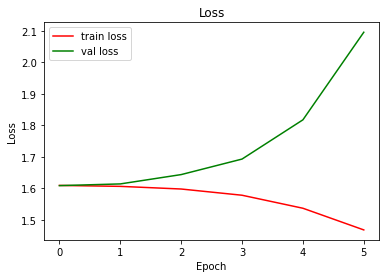

In [42]:
# plot loss
plt.plot(history.history['loss'],label='train loss',color='r')
plt.plot(history.history['val_loss'],label='val loss',color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

#plt.savefig('vgg19-loss.png')
plt.show()

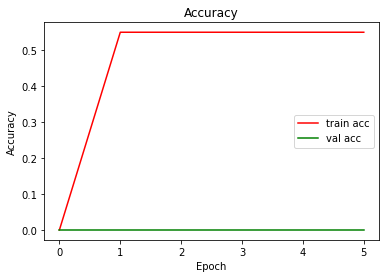

In [43]:
# plot accuracy
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

In [ ]:
#Evaluation
model.evaluate(test_x,test_y,batch_size=32)
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

# Accuracy
accuracy = accuracy_score(y_pred,test_y)

## ResNet50

In [50]:
# Create path for hc
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+'/'+'data/'+'all_deg_01'

train_path = dirname + "/data/all_deg_01/train"
test_path = dirname + "/data/all_deg_01/test"
val_path = dirname + "/data/all_deg_01/val"


In [13]:
# Renaming the each data
for data_folder in os.listdir(data_path):  
    if data_folder == '.DS_Store':
        continue
    sub_path=data_path+data_folder
    for folder in os.listdir(sub_path):
        if folder == '.DS_Store':
            continue
        subj_path=sub_path+'/'+folder
        if os.path.basename(subj_path) == 'pd':   
            for i, filename in enumerate(os.listdir(subj_path)):
                dst = f"1_{str(i)}.png"
                src = f"{subj_path}/{filename}"
                dst = f"{subj_path}/{dst}"
                os.rename(src,dst)
        elif os.path.basename(subj_path) == 'hc':   
            for i, filename in enumerate(os.listdir(subj_path)):
                dst = f"0_{str(i)}.png"
                src = f"{subj_path}/{filename}"
                dst = f"{subj_path}/{dst}"
                os.rename(src,dst) 
     

In [33]:
data_path+'training'

'/Users/zaw/Desktop/smooth_pursuit/data/all_deg_01/training'

In [14]:
def prepare_df(data_type):
    s_path = data_path+data_type+'/'
    X = []
    y = []
    for i in os.listdir(s_path):
        if i == '.DS_Store':
            continue
        sub_path = s_path+i
        for j in os.listdir(sub_path):   
            if j == '.DS_Store':
                continue
                # Image
            X.append(j)
                # Label
            y.append(j.split('_')[0])

    X = np.array(X)
    y = np.array(y)

    df = pd.DataFrame()
    df['filename'] = X
    df['label'] = y

    return df

In [15]:
df_train = prepare_df('train')
df_val   = prepare_df('val')
df_test  = prepare_df('test')

In [30]:
df_test.head()

,filename,label
0,1_13.png,1
1,1_12.png,1
2,1_10.png,1
3,1_9.png,1
4,1_8.png,1


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory= data_path+'/'+'train',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),validate_filenames=False
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    directory =  data_path+'/'+'val',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),validate_filenames=False
)



Found 187 non-validated image filenames belonging to 2 classes.
Found 47 non-validated image filenames belonging to 2 classes.


In [55]:
from tensorflow.keras.applications import ResNet50

# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(224, 224, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(224, 224, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  verbose=1)
history = model.fit(train_generator, epochs=20, validation_data=val_generator,callbacks=[es])

Epoch 1/20
6/6 [==============================] - 6s 1s/step - loss: 0.6936 - accuracy: 0.5455 - val_loss: 0.6004 - val_accuracy: 0.7660
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 0.6811 - accuracy: 0.5668 - val_loss: 0.5805 - val_accuracy: 0.5957
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 0.6813 - accuracy: 0.5615 - val_loss: 0.5807 - val_accuracy: 0.8298
Epoch 4/20
6/6 [==============================] - 6s 992ms/step - loss: 0.6786 - accuracy: 0.5294 - val_loss: 0.6163 - val_accuracy: 0.6809
Epoch 5/20
6/6 [==============================] - 6s 1s/step - loss: 0.6990 - accuracy: 0.5775 - val_loss: 0.6279 - val_accuracy: 0.5745
Epoch 6/20
6/6 [==============================] - 6s 1s/step - loss: 0.6926 - accuracy: 0.5508 - val_loss: 0.5684 - val_accuracy: 0.7872
Epoch 7/20
6/6 [==============================] - 6s 1s/step - loss: 0.6785 - accuracy: 0.5134 - val_loss: 0.6049 - val_accuracy: 0.5745
Epoch 8/20
6/6 [======================

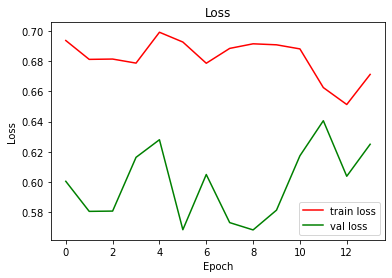

In [58]:
# loss
plt.plot(history.history['loss'],label='train loss',color='r')
plt.plot(history.history['val_loss'],label='val loss',color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

#plt.savefig('vgg19-loss.png')
plt.show()

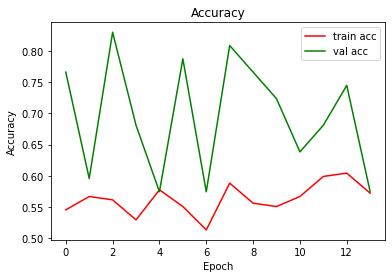

In [59]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

## Another model

In [61]:
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(200, 200, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [64]:
model.compile(optimizer=RMSprop(learning_rate=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')

In [67]:
history = model.fit(train_generator,
epochs=15,
verbose=1,
validation_data = val_generator,
validation_steps=8)

Epoch 1/15
6/6 [==============================] - 4s 601ms/step - loss: 1.3525 - accuracy: 0.5187 - val_loss: 1.2140 - val_accuracy: 0.5532
Epoch 2/15
6/6 [==============================] - 3s 512ms/step - loss: 1.2699 - accuracy: 0.4866
Epoch 3/15
6/6 [==============================] - 3s 412ms/step - loss: 1.0727 - accuracy: 0.5348
Epoch 4/15
6/6 [==============================] - 2s 393ms/step - loss: 1.3468 - accuracy: 0.4813
Epoch 5/15
6/6 [==============================] - 3s 421ms/step - loss: 1.0194 - accuracy: 0.5348
Epoch 6/15
6/6 [==============================] - 3s 409ms/step - loss: 1.5554 - accuracy: 0.4492
Epoch 7/15
6/6 [==============================] - 2s 392ms/step - loss: 1.4925 - accuracy: 0.4171
Epoch 8/15
6/6 [==============================] - 2s 396ms/step - loss: 1.0088 - accuracy: 0.5187
Epoch 9/15
6/6 [==============================] - 2s 412ms/step - loss: 1.0857 - accuracy: 0.5508
Epoch 10/15
6/6 [==============================] - 3s 414ms/step - loss: 1.2

In [68]:
model.evaluate(val_generator)

2/2 [==============================] - 1s 385ms/step - loss: 0.7048 - accuracy: 0.5745


[0.7047956585884094, 0.5744681358337402]

In [70]:
STEP_SIZE_TEST=val_generator.n//val_generator.batch_size
val_generator.reset()
preds = model.predict(val_generator,
verbose=1)

2022-03-15 20:14:59.779742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 259ms/step


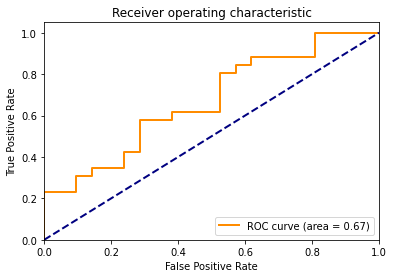

In [73]:
from sklearn.metrics import auc
fpr, tpr, _ = roc_curve(val_generator.classes, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()